In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.stats import linregress

## Week 11 Magnetism

In [2]:
# load data
def file_name(number):
    return f"resources/data/exp{number}.csv"

data0_table = np.genfromtxt(file_name(0), delimiter=',', skip_header=1)
data0= {
    "time": data0_table[:,0], # time, s
    "bx": data0_table[:,1],   # bx, uT
    "bz": data0_table[:,2],   # bz, uT
}
data1_table = np.genfromtxt(file_name(1), delimiter=',', skip_header=1)
data1 = {
    "time": data1_table[:,0], # time, s
    "high_gain": data1_table[:,7], # high gain, V
    "gyro_y": data1_table[:,5], # gyro y, rad/s
}

def get_data_slice(data, begin_second, end_second):
    if begin_second < 1/200: begin_second = 1/200
    return {key: value[int(begin_second*200-1):int(end_second*200-1)] for key, value in data.items()}

### Pre test
1. parametric plot bx vx bz

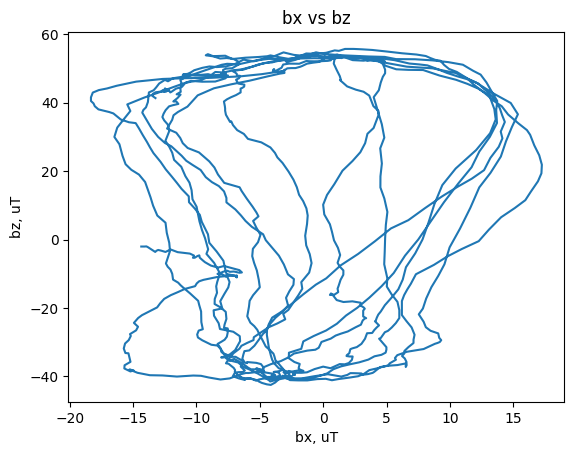

In [3]:
def part0():
    plt.plot(data0["bx"], data0["bz"])
    plt.xlabel("bx, uT")
    plt.ylabel("bz, uT")
    plt.title("bx vs bz")
    plt.show()
part0()

### Part 1
1. high gain: "high gain check.png"
2. parametric plot high gain vs gyro

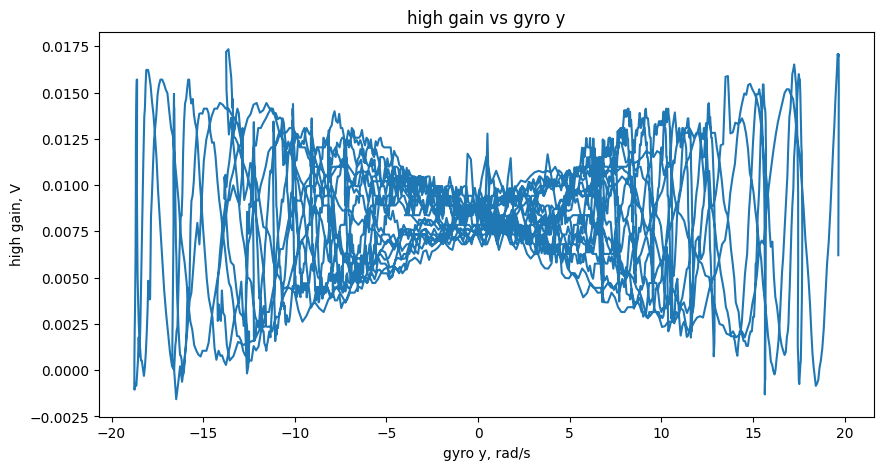

In [12]:
def part1():
    p1 = get_data_slice(data1, 15, 80)
    plt.plot(p1["gyro_y"], p1["high_gain"])
    plt.ylabel("high gain, V")
    plt.xlabel("gyro y, rad/s")
    plt.title("high gain vs gyro y")
    plt.gcf().set_size_inches(10, 5)
    plt.show()
part1()

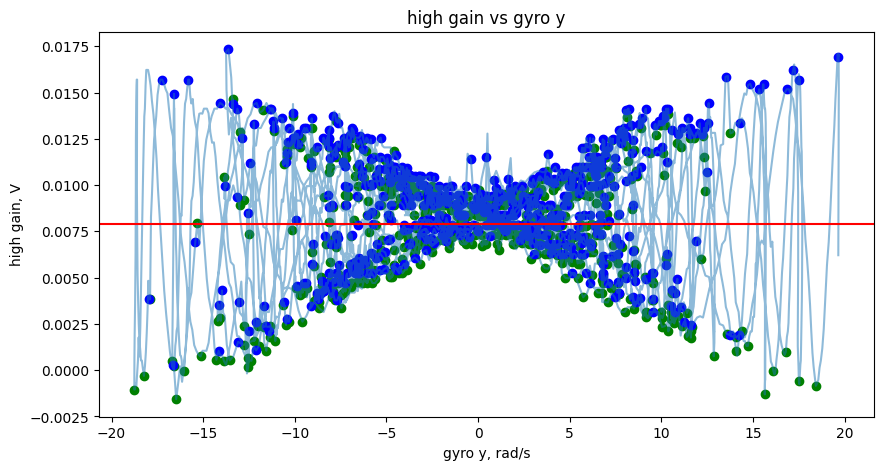

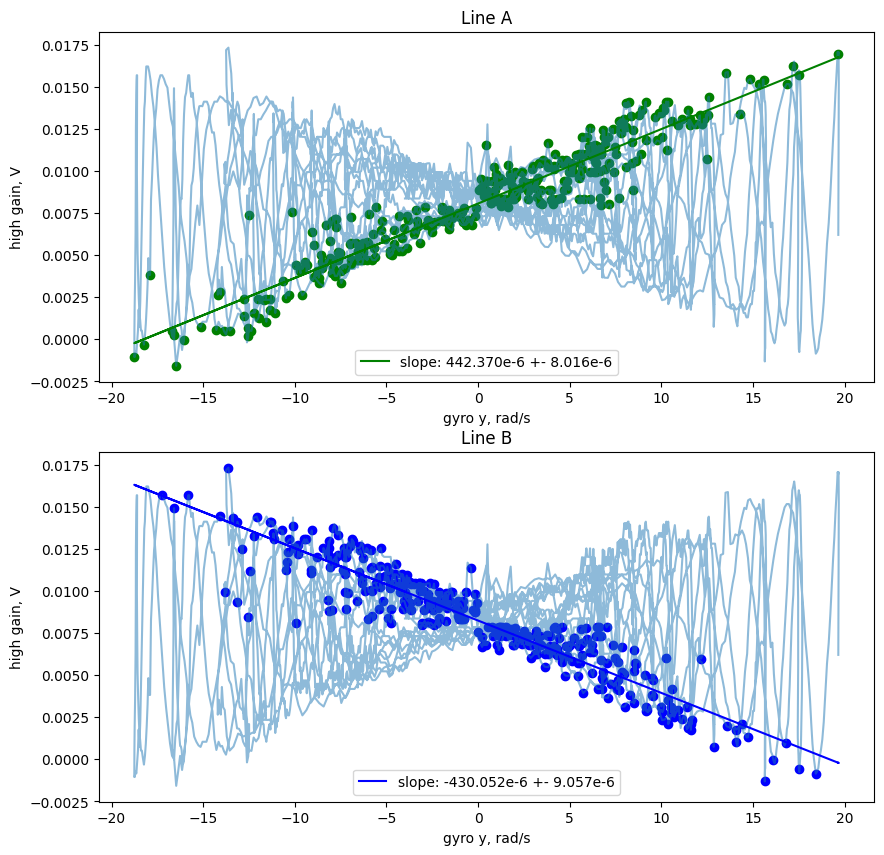

('442.370e-6 +- 8.016e-6', '-430.052e-6 +- 9.057e-6')


In [51]:
# to determine the slope of the lines in the envelope above:
# 1. find the center of the envelope
# 2. find every local maximum and minumum of the envelope
# 3. plot the max and min points

def find_envelope(gain, gyro):
    # find the center of the envelope
    center = (max(gain) + min(gain)) / 2
    
    maxs = []
    mins = []
    
    #for every point where derivative changes sign, it is a max or min
    for i in range(1, len(gyro)-1):
        if np.gradient(gain)[i] > 0 and np.gradient(gain)[i-1] < 0:
            maxs.append(i)
        if np.gradient(gain)[i] < 0 and np.gradient(gain)[i-1] > 0:
            mins.append(i)

    return center, maxs, mins

def plot_envelope(data, center, maxs, mins):
    #fade the gyro vs high gain line
    plt.plot(data["gyro_y"], data["high_gain"], alpha=0.5)
    plt.axhline(center, color='r')
    plt.scatter(data["gyro_y"][maxs], data["high_gain"][maxs], color='g')
    plt.scatter(data["gyro_y"][mins], data["high_gain"][mins], color='b')
    plt.ylabel("high gain, V")
    plt.xlabel("gyro y, rad/s")
    plt.title("high gain vs gyro y")
    plt.gcf().set_size_inches(10, 5)
    plt.show()
    
    # combine the maxs from -20 to 0 and the mins from 0 to 20
    line_a = [maxs[i] for i in range(len(maxs)) if data["gyro_y"][maxs[i]] < 0] + [mins[i] for i in range(len(mins)) if data["gyro_y"][mins[i]] > 0]
    line_b = [maxs[i] for i in range(len(maxs)) if data["gyro_y"][maxs[i]] > 0] + [mins[i] for i in range(len(mins)) if data["gyro_y"][mins[i]] < 0]
    
    # for line_a, keep just the points below the center before gyro=0 and those above the center after gyro=0
    # for line_b, keep just the points above the center before gyro=0 and below the center after gyro=0
    line_a = [i for i in line_a if data["high_gain"][i] < center and data["gyro_y"][i] < 0] + [i for i in line_a if data["high_gain"][i] > center and data["gyro_y"][i] > 0]
    line_b = [i for i in line_b if data["high_gain"][i] > center and data["gyro_y"][i] < 0] + [i for i in line_b if data["high_gain"][i] < center and data["gyro_y"][i] > 0]

    #find the slope of the lines
    slope_a, intercept_a, r_value_a, p_value_a, std_err_a = linregress(data["gyro_y"][line_a], data["high_gain"][line_a])
    slope_b, intercept_b, r_value_b, p_value_b, std_err_b = linregress(data["gyro_y"][line_b], data["high_gain"][line_b])
    
    #graph the lines in subplots and their fits. label the fits
    fig, axs = plt.subplots(2, 1)
    axs[0].plot(data["gyro_y"], data["high_gain"], alpha=0.5)
    axs[0].scatter(data["gyro_y"][line_a], data["high_gain"][line_a], color='g')
    axs[0].plot(data["gyro_y"], slope_a*data["gyro_y"] + intercept_a, color='g', label=f"slope: {slope_a*10**6:.3f}e-6 +- {std_err_a*10**6:.3f}e-6")
    axs[0].legend()
    axs[0].set_title("Line A")
    axs[0].set_ylabel("high gain, V")
    axs[0].set_xlabel("gyro y, rad/s")
    
    
    axs[1].plot(data["gyro_y"], data["high_gain"], alpha=0.5)
    axs[1].scatter(data["gyro_y"][line_b], data["high_gain"][line_b], color='b')
    axs[1].plot(data["gyro_y"], slope_b*data["gyro_y"] + intercept_b, color='b', label=f"slope: {slope_b*10**6:.3f}e-6 +- {std_err_b*10**6:.3f}e-6")
    axs[1].set_title("Line B")
    axs[1].set_ylabel("high gain, V")
    axs[1].set_xlabel("gyro y, rad/s")
    axs[1].legend()
    plt.gcf().set_size_inches(10, 10)
    plt.show()
    
    #return the slopes
    return f"{slope_a*10**6:.3f}e-6 +- {std_err_a*10**6:.3f}e-6", f"{slope_b*10**6:.3f}e-6 +- {std_err_b*10**6:.3f}e-6"
def part1_envelope():
    p1 = get_data_slice(data1, 15, 80)
    center, maxs, mins = find_envelope(p1["high_gain"], p1["gyro_y"])
    slopes = plot_envelope(p1, center, maxs, mins)
    print(slopes)
part1_envelope()